P0 (Bayes) = 0.77 (0.52, 0.91) IQR = 0.39
P0 (Gradient descent) = 0.77 (0.53, 0.91) IQR = 0.38
Significant difference at p-value of 0.0051
U = 97192
Cliff's δ = 0.725

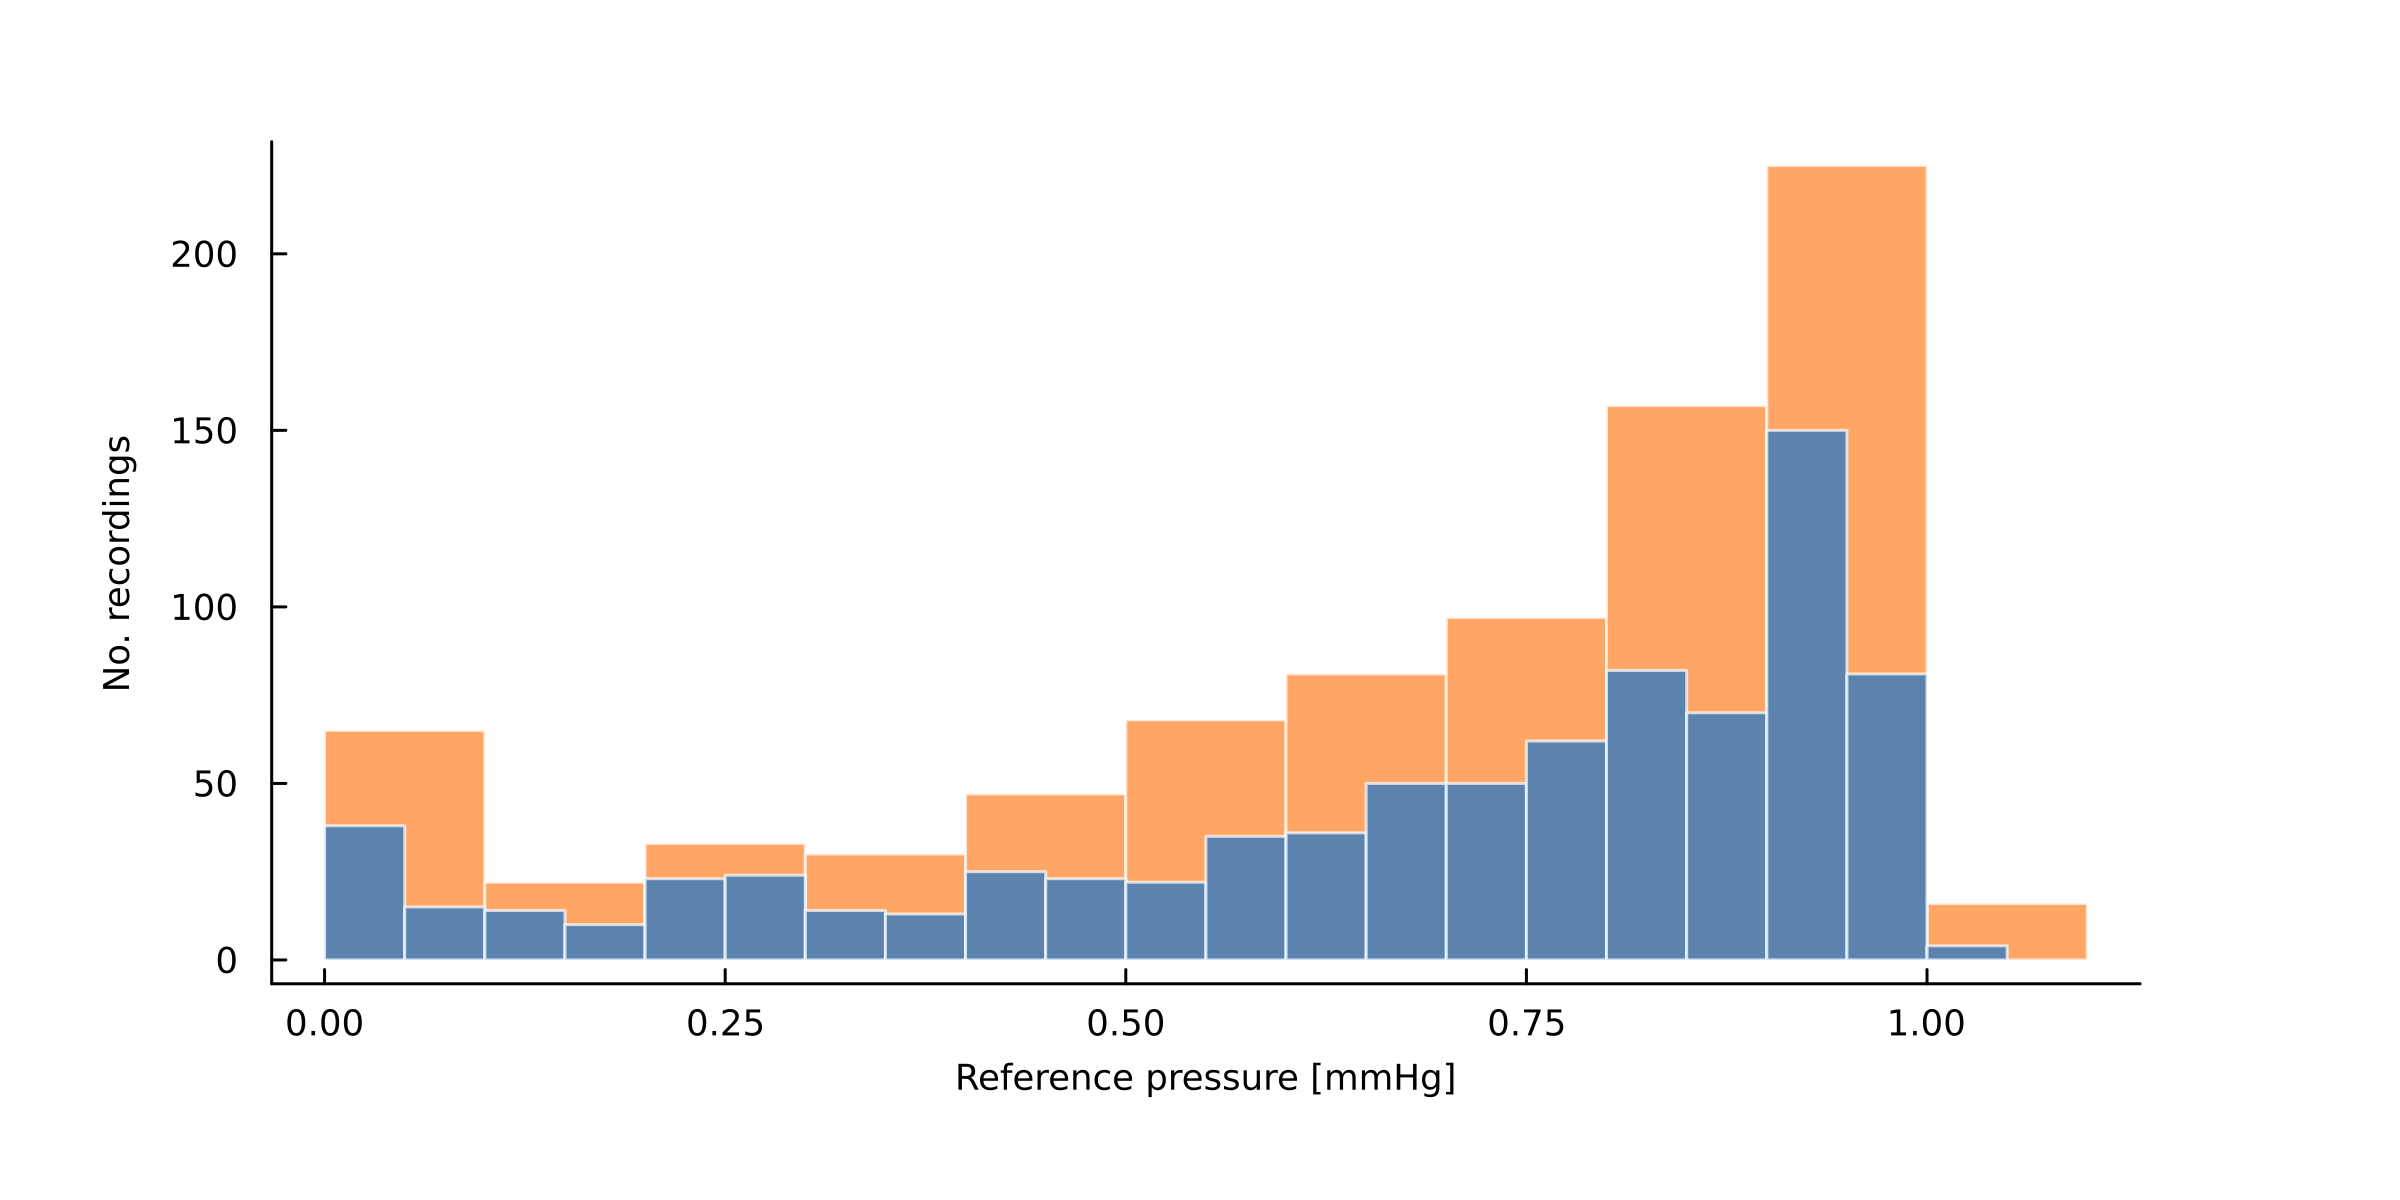

In [139]:
using CSV, DataFrames, StatsPlots, StatsBase, Printf, LaTeXStrings, HypothesisTests, Distributions, Measures

df_standard = CSV.File("/Users/jjc/CSF/results_apr2023/Results_standard.csv")
df_icm = CSV.File("/Users/jjc/CSF/Results/results_feb2023/Results_standard.csv")
df_Pss = CSV.File("/Users/jjc/CSF/results_apr2023/Results_Pss.csv")
df_4 = CSV.File("/Users/jjc/CSF/results_apr2023/Results_4.csv")
df_2parameters = CSV.File("/Users/jjc/CSF/results_apr2023/Results_2.csv")

parameters = ["RMSE_mean", "Rcsf_mean", "Ib_mean", "P0_mean", "E_mean", "R2_mean"]
optmethod = ["Results_standard", "Results_Pss", "Results_4", "Results_2parameters"]
X = [[1], [3], [5], [7]]
clrs = [:orange, :cyan4, :grey, :green]


res = DataFrame(df_standard)
res_icm = DataFrame(df_icm)
# res = DataFrame(df_Pss)

torm = .~(df_standard["exclude"].==1)

rdigit = 2

variable = res.R2_median
torm = torm .&& .~(variable .< -15.0) .&& .~isnan.(variable) .&& .~(variable .> 50)
variable_bayes = variable[torm]
variable_bayes = round.(variable_bayes, digits=rdigit)
q1 = percentile(filter(!isnan, variable_bayes),25)
q3 = percentile(filter(!isnan, variable_bayes),75)
print(@sprintf("P0 (Bayes) = %0.2f (%0.2f, %0.2f) IQR = %0.2f\n", median(filter(!isnan, variable_bayes)),q1, q3, q3-q1))


variable = res_icm.R2_icm
variable_icm = variable[torm]
variable_icm = round.(variable_icm, digits=rdigit)
q1 = percentile(filter(!isnan, variable_icm),25)
q3 = percentile(filter(!isnan, variable_icm),75)
print(@sprintf("P0 (Gradient descent) = %0.2f (%0.2f, %0.2f) IQR = %0.2f\n", median(filter(!isnan, variable_icm)), q1, q3, q3-q1))

# threshold = 12
# print("\nR > 12, ICM ", sum(variable_icm .> threshold))
# print("\nR > 12, Bayes ", sum(variable_bayes .> threshold))
# print("\nR < 12, ICM ", sum(variable_icm .<= threshold))
# print("\nR < 12, Bayes ", sum(variable_bayes .<= threshold))
# diff_diag = sum(variable_icm .> threshold .&& variable_bayes .<= threshold) + sum(variable_icm .<= threshold .&& variable_bayes .> threshold)
# diff_diag_prct = 100 * diff_diag / length(variable_icm)
# print("\nNumber of patients with changed diagnosis (threshold = ", threshold, "): ", diff_diag, " (", round(diff_diag_prct, digits=1), "%)\n")

# OneSampleADTest(variable_bayes, Normal())
# ExactOneSampleKSTest(variable_bayes, Normal())

tres = SignedRankTest(variable_bayes, variable_icm)
pval = pvalue(tres)

U = tres.W
VDA = U/(length(variable_bayes)*length(variable_icm))
CD = abs((VDA-0.5)*2)

if pval < 0.05
    print(@sprintf("Significant difference at p-value of %0.4f", pval))
    print(@sprintf("\nU = %0.0f", U))
    print(@sprintf("\nCliff's δ = %0.3f", CD))
else
    print(@sprintf("\nDifference not significant at p-value of %0.4f", pval))
end


pb = res.P_b[torm]

# print("\nNumber outside of range ICM: ", sum(variable_icm .< -10.0 .|| variable_icm .>= pb))
# print("\nNumber outside of range Bayes: ", sum(variable_bayes .< -10.0 .|| variable_bayes .>= pb))

# histogram(variable_bayes, alpha=.7, size=(800,400), margin=10mm, rightmargin=20mm, linecolor=:white, color=:chocolate1, xlabel="Elasticity coefficient [1/mL]", ylabel="No. recordings", dpi=300, grid=false, legend=false, xlim=(:auto, mean(variable_bayes)+3*std(variable_bayes)), tickfontsize=fontsize, labelfontsize=fontsize, legendfontsize=16, titlefontsize=fontsize)
fontsize=8
histogram(variable_bayes, alpha=.7, size=(800,400), margin=10mm, rightmargin=20mm, linecolor=:white, color=:chocolate1, xlabel="Reference pressure [mmHg]", ylabel="No. recordings", dpi=300, grid=false, legend=false, xlim=(:auto, :auto), tickfontsize=fontsize, labelfontsize=fontsize, legendfontsize=16, titlefontsize=fontsize)
histogram!(variable_icm, bins=20, alpha=.7, size=(800,400), margin=10mm, rightmargin=20mm, linecolor=:white, color=:dodgerblue3, xlabel="Reference pressure [mmHg]", ylabel="No. recordings", dpi=300, grid=false, legend=false, xlim=(:auto, :auto), tickfontsize=fontsize, labelfontsize=fontsize, legendfontsize=16, titlefontsize=fontsize)


# savefig("/Users/jjc/CSF/texfiles/P0_std.pdf")

# tres

# minimum(variable_bayes)

In [187]:
using HypothesisTests, Bootstrap, Statistics


# Define the equivalence margin (Δ)
equivalence_margin = 0.13 # Replace with your chosen margin of equivalence

# Calculate the Hodges-Lehmann estimator
differences = variable_bayes.-variable_icm
hl_estimator = median(differences)

n_boot = 10000

bs1 = bootstrap(std, differences, BasicSampling(n_boot))

# calculate 90% confidence intervals
cil = 0.90
ci = confint(bs1, PercentileConfInt(cil));

if -equivalence_margin < ci[1][2] < equivalence_margin && -equivalence_margin < ci[1][3] < equivalence_margin
    println("The two methods are equivalent within the margin of equivalence.")
else
    println("The two methods are not equivalent within the margin of equivalence.")
end

println("Hodges-Lehmann estimator: ", hl_estimator)
println("Confidence interval: ", ci[1])


ArgumentError: ArgumentError: quantiles are undefined in presence of NaNs or missing values

In [152]:
using Measures

fontsize = 24
histogram(variable_bayes,bins=10, color=:dodgerblue3, linecolor=:white, label="Bayesian")
histogram!(variable_icm, bins=10, alpha=.7, size=(800,400), margin=10mm, rightmargin=20mm, linecolor=:white, color=:chocolate1, xlabel="R² of the P-V curve", ylabel="No. recordings", label="Gradient descent", dpi=300, grid=false, legend=true, xlim=(0,1.1), tickfontsize=fontsize, labelfontsize=fontsize, legendfontsize=16, titlefontsize=fontsize)
# savefig("/Users/jjc/Desktop/P0.pdf")
savefig("/Users/jjc/CSF/texfiles/R2.pdf")



"/Users/jjc/CSF/texfiles/R2.pdf"

In [191]:
using HypothesisTests, CSV, Plots, StatsPlots, StatsBase, LaTeXStrings, DataFrames, OutlierDetection, KernelDensity


violin([variable_icm, variable_bayes], label=false, side=:left)
boxplot!([variable_icm, variable_bayes], ylims=[0,2], bar_width=.5, xlims=[0,3])


ArgumentError: ArgumentError: quantiles are undefined in presence of NaNs or missing values

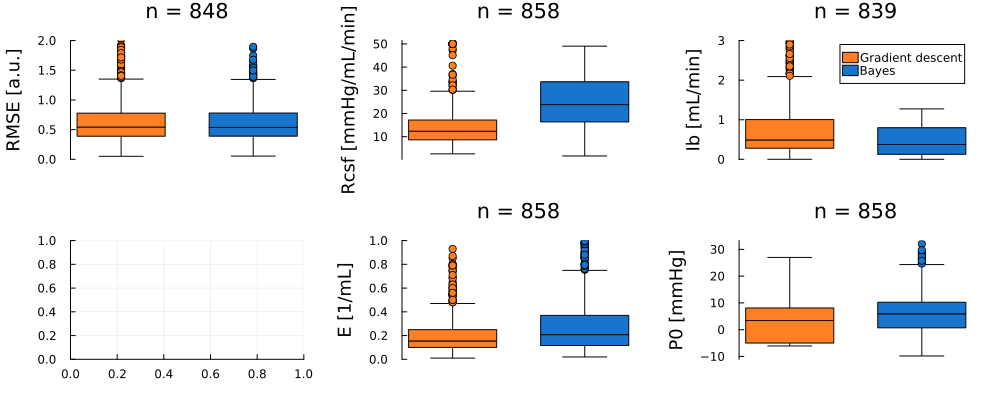

In [16]:
using Measures
res = DataFrame(df_4)
# theme(:ggplot2)
torm = .~(df_standard["exclude"].==1)
var_bayes = res.RMSE_median
torm = torm .&& .~(var_bayes .< 0.00000001) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.RMSE_icm[torm]


boxplot([1], var_icm, bar_width=0.5, color=:chocolate1)
h1 = boxplot!([1.75], var_bayes, bar_width=0.5, ylim=[0,2], color=:dodgerblue3, xaxis=false, ylabel="RMSE [a.u.]", legend=false, grid=false)
title!(@sprintf("n = %0.0f", length(var_bayes)))
plot(h1, legend=false, grid=false, xlim=[.7, 2], size=(200,500), margin=5mm)

torm = .~(df_standard["exclude"].==1)
var_bayes = res.Rcsf_median
torm = torm .&& .~(var_bayes .< 0.00000001) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.Rcsf_icm[torm]

boxplot([1], var_icm, bar_width=0.5, color=:chocolate1)
h2 = boxplot!([1.75], var_bayes, bar_width=0.5, color=:dodgerblue3, xaxis=false, ylabel="Rcsf [mmHg/mL/min]", legend=false, grid=false)
title!(@sprintf("n = %0.0f", length(var_bayes)))
plot(h2, legend=false, grid=false, xlim=[.5, 2], size=(200,500), margin=5mm)

torm = .~(df_standard["exclude"].==1)
var_bayes = res.Ib_median
torm = torm .&& .~(var_bayes .< 0.00000001) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.Ib_icm[torm]

boxplot([1], var_icm, bar_width=0.5, color=:chocolate1, label="Gradient descent")
h3 = boxplot!([1.75], var_bayes, ylim=[0,3], bar_width=0.5, color=:dodgerblue3, xaxis=false, ylabel="Ib [mL/min]", legend=true, grid=false, label="Bayes")
title!(@sprintf("n = %0.0f", length(var_bayes)))
plot(h3, legend=false, grid=false, xlim=[.5, 2], size=(200,500), margin=5mm)

torm = .~(df_standard["exclude"].==1)
var_bayes = res.R2_median
torm = torm .&& .~(var_bayes .< 0.00000001) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.R2_icm[torm]

# boxplot([1], var_icm, bar_width=0.5, color=:chocolate1)
# h4 = boxplot!([1.75], var_bayes, bar_width=0.5, ylim=[0,1], color=:dodgerblue3, xaxis=false, ylabel="R² of P-V curve", legend=false, grid=false)
# title!(@sprintf("n = %0.0f", length(var_bayes)))
# plot(h4, legend=false, grid=false, xlim=[.5, 2], size=(200,500), margin=5mm)

h4 = boxplot()

torm = .~(df_standard["exclude"].==1)
var_bayes = res.E_median
torm = torm .&& .~(var_bayes .< 0.00000001) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.E_icm[torm]

boxplot([1], var_icm, bar_width=0.5, color=:chocolate1)
h5 = boxplot!([1.75], var_bayes,ylim=[0,1], bar_width=0.5, color=:dodgerblue3, xaxis=false, ylabel="E [1/mL]", legend=false, grid=false)
title!(@sprintf("n = %0.0f", length(var_bayes)))
plot(h5, legend=false, grid=false, xlim=[.5, 2], size=(200,500), margin=5mm)

torm = .~(df_standard["exclude"].==1)
var_bayes = res.P0_median
torm = torm .&& .~(var_bayes .< -20) .&& .~isnan.(var_bayes) .&& .~(var_bayes .> 50)
var_bayes = var_bayes[torm]
var_icm = res.P0_icm[torm]

boxplot([1], var_icm, bar_width=0.5, color=:chocolate1, label="Old (Gradient descent)")
h6 = boxplot!([1.75], var_bayes, bar_width=0.5, legendlabel="New (Bayes)", color=:dodgerblue3, xaxis=false, ylabel="P0 [mmHg]", legend=false, grid=false)
title!(@sprintf("n = %0.0f", length(var_bayes)))
plot(h6, legend=false, grid=false, xlim=[.5, 2], size=(200,500), margin=5mm)

plot(h1,h2,h3,h4,h5,h6, layout=grid(2,3), margin=5mm, size=(1000, 400), labelfontsize=12)

# savefig("/Users/jjc/Desktop/all_boxplots_4params.png")


# df_standard = CSV.File("/Users/jjc/CSF/results_feb2023/Results_standard_v2.csv")y
# df_Pss = CSV.File("/Users/jjc/CSF/results_feb2023/Results_Pss.csv")
# df_4 = CSV.File("/Users/jjc/CSF/results_feb2023/Results_4.csv")
# df_2parameters = CSV.File("/Users/jjc/CSF/results_feb2023/Results_2params.csv")

In [6]:
DF = df_standard
all = sum(DF["exclude"].<1)
excl = sum(DF["convergence"].<1.3)
excl_low = sum(DF["convergence"].<1.2)

all - excl
# all - excl_low

print(excl, "/858 (", 100*round(excl/858, digits=2), "%)")
print("\n", excl_low, "/858 (", 100*round(excl_low/858, digits=2), "%)")

850/858 (99.0%)
838/858 (98.0%)

In [4]:
using ColorSchemes, Measures, LaTeXStrings, LinearAlgebra
using PyPlot
pygui(true)


res = DataFrame(df_standard)

var = res.R2_median
R2 = var

torm = isnan.(R2) .|| R2 .< 0.000000000000001

var = res.Rcsf_median
var = var[.~torm]
Rcsf = var

var = res.E_median
var = var[.~torm]
E = var

var = res.P0_median
var = var[.~torm]
P0 = var

var = res.Ib_median
var = var[.~torm]
Ib = var

var = res.RMSE_median
var = var[.~torm]
RMSE = var

var = res.R2_median
var = var[.~torm]
R2 = var

var = res.P_b
var = var[.~torm]
Pb = var

var = res.P_p
var = var[.~torm]
Pp = var

##############
var = res.Rcsf_std
var = var[.~torm]
Rcsf_std = var

var = res.E_std
var = var[.~torm]
E_std = var

var = res.P0_std
var = var[.~torm]
P0_std = var

var = res.Ib_std
var = var[.~torm]
Ib_std = var

# var = res.above_Pss
# var = var[.~torm]
# oPss = var

# var = res.over_forty
# var = var[.~torm]
# o40 = var

var = res.Pss
var = var[.~torm]
Pss = var


datamat = hcat(Rcsf, E, P0, Ib, RMSE, R2, Pb, Pp, Rcsf_std, E_std, P0_std, Ib_std)

cormat = cor(datamat)
cormat = cormat' * cormat # make it positive semi-definite
# cormat = LowerTriangular(cormat) # mask the upper triangle

# labels = [L"R_{\mathrm{out}}", L"E", L"P_0", L"I_{\mathrm{f}}", L"\epsilon", L"R^2", L"P_{\mathrm{b}}", L"P_{\mathrm{p}}", L"R_{\mathrm{out}}\sigma", L"E \sigma", L"P_0 \sigma", L"I_{\mathrm{f}}\sigma"]
# h = heatmap(cormat, xticks=(1:length(labels)+1, labels), yticks=(1:length(labels)+1,labels), clim=(-1,1), rightmargin=15mm,color=:berlin, aspect_ratio=:equal, xlim=[0.5,length(labels)+0.5], ylim=[0.5,length(labels)+0.5], grid=false)
# a = cormat
# nrow=length(labels)
# ncol=nrow
# fontsize=8
# ann = [(i,j, text(round(a[j,i], digits=2), fontsize, :white, :center))
#             for i in 1:nrow for j in 1:ncol]
# annotate!(ann, linecolor=:white, dpi=300, size=(1000,1000), tickfontsize=16)
# xaxis!(h, rotation = 45)

# title = "2 parameters"
# title!(title)
# savefig("/Users/jjc/Desktop/correlation_matrix_"*title*".png")
# savefig("/Users/jjc/CSF/texfiles/corr_bayes.png")

for j in 1:size(cormat, 1), i in j+1:size(cormat, 2)
    cormat[i, j] = NaN
end

# Plot the lower triangle heatmap
imshow(cormat, interpolation="none", origin="lower")
# colorbar()
# box(false)
# PyPlot.savefig("heatmap.png")
show()


In [69]:
using ColorSchemes, Measures


res = DataFrame(df_icm)

var = res.R2_icm
R2 = var

torm = isnan.(R2) .|| R2 .< 0.000000000000001

var = res.Rcsf_icm
var = var[.~torm]
Rcsf = var

var = res.E_icm
var = var[.~torm]
E = var

var = res.P0_icm
var = var[.~torm]
P0 = var

var = res.Ib_icm
var = var[.~torm]
Ib = var

var = res.RMSE_icm
var = var[.~torm]
RMSE = var

var = res.R2_icm
var = var[.~torm]
R2 = var

var = res.P_b
var = var[.~torm]
Pb = var

var = res.P_p
var = var[.~torm]
Pp = var

# var = res.above_Pss
# var = var[.~torm]
# oPss = var

# var = res.over_forty
# var = var[.~torm]
# o40 = var

var = res.Pss
var = var[.~torm]
Pss = var


datamat = hcat(Rcsf, E, P0, Ib, RMSE, R2, Pb, Pp)

cormat = cor(datamat)

labels = [L"R_{\mathrm{out}}", L"E", L"P_0", L"I_{\mathrm{f}}", L"\epsilon", L"R^2", L"P_{\mathrm{b}}", L"P_{\mathrm{p}}"]
# labels = ["Rout", "E", "P₀", "Ib", "error", "R²", "baseline", "plateau"]
heatmap(cormat, xticks=(1:length(labels)+1, labels), yticks=(1:length(labels)+1,labels), clim=(-1,1), rightmargin=15mm,color=:berlin, aspect_ratio=:equal, xlim=[0.5,length(labels)+0.5], ylim=[0.5,length(labels)+0.5], grid=false)
a = cormat
nrow=length(labels)
ncol=nrow
fontsize=8
ann = [(i,j, text(round(a[i,j], digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
annotate!(ann, linecolor=:white, dpi=300, size=(600,600), tickfontsize=16)
# title = "ICM+"
# title!(title)
# savefig("/Users/jjc/Desktop/correlation_matrix_"*title*".png")
savefig("/Users/jjc/CSF/texfiles/corr_icm.png")


"/Users/jjc/CSF/texfiles/corr_icm.png"

In [4]:
using PyPlot
pygui(true)

for i in 1:size(cormat, 1), j in i+1:size(cormat, 2)
    cormat[i, j] = NaN
end

# Plot the lower triangle heatmap
imshow(cormat, interpolation="none", origin="lower")
# colorbar()
# PyPlot.savefig("heatmap.png")
show()

UndefVarError: UndefVarError: cormat not defined

NaN